In [ ]:
# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape )
print('label shape:', Y.shape )
print(Y[:200])

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)
[ 1.  9.  2.  2.  7.  1.  8.  3.  3.  7.  7.  5.  0.  1.  2.  9.  2.  7.
  7.  9.  9.  8.  5.  8.  1.  2.  3.  7.  5.  5.  6.  0.  9.  0.  2.  5.
  0.  0.  2.  9.  5.  7.  2.  4.  8.  6.  0.  8.  3.  9.  9.  4.  3.  9.
  8.  1.  6.  0.  3.  1.  9.  6.  4.  0.  2.  9.  3.  0.  9.  3.  8.  6.
  3.  1.  2.  2.  3.  2.  5.  1.  1.  8.  3.  7.  4.  6.  3.  1.  0.  9.
  2.  7.  4.  8.  7.  1.  6.  7.  8.  3.  3.  2.  3.  4.  9.  0.  4.  4.
  4.  3.  5.  6.  4.  8.  3.  8.  9.  1.  0.  4.  7.  2.  7.  2.  0.  6.
  8.  6.  8.  1.  8.  5.  5.  1.  2.  9.  2.  7.  5.  9.  7.  5.  6.  8.
  1.  6.  4.  2.  6.  7.  1.  4.  7.  9.  4.  8.  8.  4.  7.  1.  0.  6.
  4.  5.  1.  1.  4.  8.  1.  2.  7.  1.  5.  7.  7.  8.  9.  5.  5.  6.
  0.  3.  7.  4.  0.  2.  8.  8.  1.  9.  1.  0.  5.  2.  9.  4.  4.  1.
  8.  6.]


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

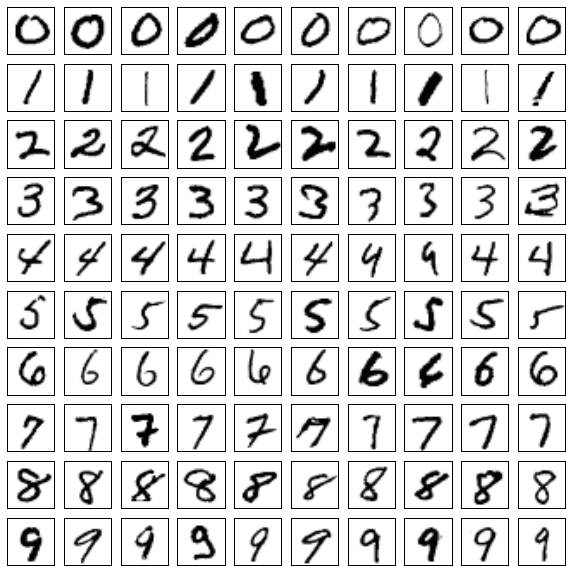

In [7]:
### STUDENT START ###
def P1(num_examples=10):
    # Set the plot colormap & size 
    plt.rc('image',cmap="Greys")
    # Autimatically set the plot size in a (num_examples,len(np.unique(Y)) dimension
    plt.figure( figsize=(num_examples, len(np.unique(Y)) ) )
         
    # Loop over each of the grid with the digits * num_examples (10*10) dimenstion      
    for digit in range(len(np.unique(Y))):
        # Extract 10 example for each digit
        examples = X[np.where(Y == digit)[0][:num_examples]]
        # Yield the elements of an iterator as well as an index number 
        for index, image in enumerate(examples):
            # Setup the subplot in (Digit, col,  position)
            plt.subplot(len(np.unique(Y)), num_examples, digit * num_examples + index + 1)
            # Reshape the image into a 28 x 28 matrix
            #plt.imshow(image.reshape(28,28))
            plt.imshow(image.reshape(28,28))
            # Get current ax instance and then hide its tickmarks/scales
            ax = plt.gca() 
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            # Or hide the entir axes with one of the following commands
            # plt.axis('off')
            # ax.set_axis_off()
### STUDENT END ###

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [8]:
### STUDENT START ###
def P2(k_values):    
    for k in k_values:
        # Create an instance of KNeighborsClassifier and then fit mini train/test datasets
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(mini_train_data, mini_train_labels)
        
        # Report accuracy and other statistics on the dev set
        if k == 1:
            # Obtain predicted labels for the dev set
            pred_labels = clf.predict(dev_data)
            score = np.mean(pred_labels == dev_labels)
            # Print out Statistics for KNN model (K=1)
            print('Accuracy for KNN model with %d neighbor(s) on the mini training set is: %0.3f' %(k, score) )
            print('For k=1, show precission, recall, and F1 for each digit:')
            print(classification_report(dev_labels, pred_labels, digits=3) )
        else:
            print( 'Accuracy for KNN model with %d neighbor(s) on the mini training set is: %0.3f' %(k, clf.score(dev_data, dev_labels))  ) 
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]

P2(k_values)

Accuracy for KNN model with 1 neighbor(s) on the mini training set is: 0.888
For k=1, show precission, recall, and F1 for each digit:
             precision    recall  f1-score   support

        0.0      0.907     0.980     0.942        99
        1.0      0.890     1.000     0.942       105
        2.0      0.988     0.794     0.880       102
        3.0      0.773     0.872     0.820        86
        4.0      0.885     0.817     0.850       104
        5.0      0.927     0.835     0.879        91
        6.0      0.940     0.959     0.949        98
        7.0      0.889     0.920     0.904       113
        8.0      0.944     0.875     0.908        96
        9.0      0.777     0.821     0.798       106

avg / total      0.892     0.888     0.888      1000

Accuracy for KNN model with 3 neighbor(s) on the mini training set is: 0.878
Accuracy for KNN model with 5 neighbor(s) on the mini training set is: 0.869
Accuracy for KNN model with 7 neighbor(s) on the mini training set is: 0.

ANSWER:  Among the five given digits, the number 9 is the most difficult one to classify. Compared with four other digits, it has the worst statistics from the KNN (k=1) model: precision (0.777), recall/sensitivity (0.821) and F1 score (0.798).  

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [35]:
def P3(train_sizes, accuracies):
### STUDENT START ###
    clf = KNeighborsClassifier(n_neighbors=1)
    
    # Print headers of train_sizes, the accuracy of KNN (k=1) model and amount of time needed
    print("Print headers of train_sizes, accuracy of KNN (k=1) model  & amount of time needed")
    print("train_sizes\t\tAccuracy\t\tTime (sec)")
    for sizes in train_sizes:
        starttime = time.time()
        clf = clf.fit(train_data[:sizes], train_labels[:sizes])
        accuracy = clf.score(dev_data, dev_labels)
        print('%d \t\t\t %.4f \t\t\t %.2f ' %(sizes, accuracy, time.time() - starttime ))
        accuracies.append(accuracy)    
    return accuracies
### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

Print headers of train_sizes, accuracy of KNN (k=1) model  & amount of time needed
train_sizes		Accuracy		Time (sec)
100 		 0.7200 		 0.11 
200 		 0.7860 		 0.20 
400 		 0.8410 		 0.43 
800 		 0.8840 		 0.96 
1600 		 0.9020 		 1.89 
3200 		 0.9260 		 3.71 
6400 		 0.9370 		 7.48 
12800 		 0.9590 		 16.34 
25000 		 0.9700 		 34.49 


[0.71999999999999997,
 0.78600000000000003,
 0.84099999999999997,
 0.88400000000000001,
 0.90200000000000002,
 0.92600000000000005,
 0.93700000000000006,
 0.95899999999999996,
 0.96999999999999997]

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

Predicted accuracy of a linear model with the training size of 60000: 1.243
Predicted accuracy of a log transformed linear model with the training size of 60000: 1.034


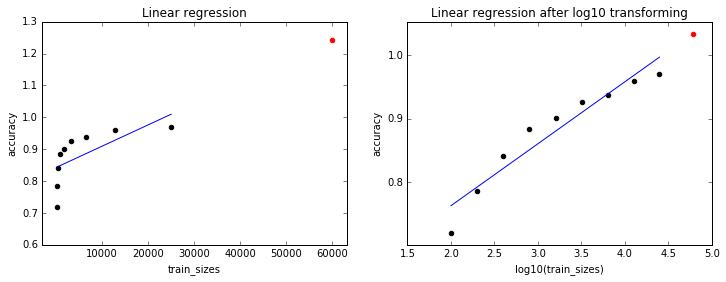

In [95]:
def P4():
### STUDENT START ###
    # (X * y.T).T
    X = np.array(train_sizes).reshape((-1,1))
    y = np.array(accuracies).reshape((-1,1))
    # X = np.array(train_sizes)[:,np.newaxis] or np.array(train_sizes).reshape(9,1)
    # y = np.array(accuracies)[:,np.newaxis]   or np.array(accuracies).reshape(9,1)
    regression_model = LinearRegression()
    regression_model.fit(X, y)
    
    # Print the prediction of linear model when the training size n=60000
    print( 'Predicted accuracy of a linear model with the training size of %d: %.3f' %(60000, regression_model.predict(60000)) )
    # Show the scatter plot of train_sizes vs. accuracy
    plt.figure(figsize=(12, 4))
    ax = plt.subplot(1, 2, 1)
    plt.setp(ax, xticks=(10000,20000,30000,40000,50000,60000))
    plt.plot(X, regression_model.predict(X))
    plt.scatter(X, y, color='black')
    plt.scatter(60000, regression_model.predict(60000), color='red')
    plt.xlabel("train_sizes")
    plt.ylabel("accuracy")
    plt.title('Linear regression')
    
    # Take a log transforming of X 
    regression_model.fit( np.log10(X), y)
    print('Predicted accuracy of a log transformed linear model with the training size of %d: %.3f' %(60000, regression_model.predict(np.log10(60000) ) ) )
    # Show the scatter plot of log10 transformed train_sizes vs. accuracy
    ax = plt.subplot(1, 2, 2)
    plt.setp(ax, yticks=(0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3))
    plt.plot( np.log10(X), regression_model.predict( np.log10(X) )  )
    plt.scatter(np.log10(X), y, color='black')
    plt.scatter(np.log10(60000), regression_model.predict(np.log10(60000)), color='red')
    #plt.scatter(60000, regression_model.predict(60000), color='red')
    plt.xlabel("log10(train_sizes)")
    plt.ylabel("accuracy")
    plt.title('Linear regression after log10 transforming')     
 ### STUDENT END ###

P4()

ANSWER: when the traninng size n=6000, the linear regression model would predict the corresponding accuracy to be 1.243.  This is not reasonable because the value itself is much larger than 100%.  This is due to the nonlinear relationship between train_sizes and observed accuracies. When the train_size exceed ~10000, the accuracy will almost reach a plateau. Therefore, if we directly apply the linear model with any larger train_size values, we probably would get some unreasonable prediction as discussed above. To fix this problem, we can first apply the log10 (or log) transforming for the given train_sizes and then fit newly transformed data into the linear model.  This will make the prediction more reasonable as show in above figures.  

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

Confusion matrix for the identification of consfused pairs:
[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]


Top 5 confused [(act, pred), counts]: [((4, 9), 14), ((5, 3), 9), ((9, 4), 9), ((9, 7), 5), ((8, 3), 5)]
print some examples of two most confused digit pairs, (4,9) and (5,3):


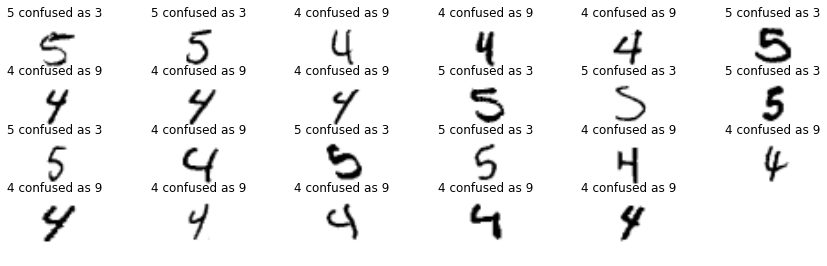

In [142]:
def P5():

### STUDENT START ###
    # Define a 1-NN model and fit the dev data
    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(mini_train_data, mini_train_labels)
    pred_labels = clf.predict(dev_data)
    
    # Print the confusion matrix 
    cm = confusion_matrix(dev_labels, pred_labels)
    print( 'Confusion matrix for the identification of consfused pairs:')
    print( cm )
    # Create a dictionary with key:value = (row,col):mismatched pairs of digits
    confusion_dict = {}
    for row in range(0,cm.shape[0]):
        for col in range(0,cm.shape[1]):
            if row != col:
                confusion_dict[(row,col)] = cm[row][col]
    # Extract top 5 most confused pairs of digits as the list of tuples sorted by values
    top_confused = sorted(confusion_dict.items(),key=lambda x:x[1], reverse=True)[:5]
    # Print 5 most confused pairs 
    print('\n')
    print('Top 5 confused [(act, pred), counts]:', top_confused)
    
    # Print some examples of the most confused digit pair (4,9) 
    plt.figure(figsize = (15,4))
    plt.set_cmap('gray_r')
    subplot_index = 0
    
    print('print some examples of two most confused digit pairs, (4,9) and (5,3):')
    for index, pair in enumerate(zip(dev_labels,pred_labels )):
        if pair in [(4,9), (5,3)]:
            subplot_index += 1
            image = dev_data[index]
            plt.subplot(4, 6, subplot_index)
            plt.imshow(image.reshape(28,28))
            plt.axis('off')
            title = '%d confused as %d' %(pair[0], pair[1])
            plt.title(title)
    
### STUDENT END ###

P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [13]:
### STUDENT START ###
def blur_digit(digit, blur_factor=0.5):
    '''
    Inputs: array of pixel values of a single digit
            blur_factor: weight of the original pixel (Pixel 5) in the blurring process, fine-tune to desired number
    Outputs: array of pixel values of the blurred digit
    '''
    # Assume the following naming scheme for the neighboring pixels:
    # Row above: pixels 1, 2, 3
    # Row with original pixel: 4, 5, 6 (5 is the original pixel)
    # Row below: pixels 7, 8, 9
    
    # Weight of neighboring pixels
    blur_neighbor = (1.0 - blur_factor) / 8
    
    # Reshape the digit pixel values and initialize the blurred digit
    pixels_side = 28
    digit = digit.reshape(pixels_side, pixels_side)
    transformed_digit = np.zeros(digit.shape)
        
    # Iterate through each pixel to map to transformed_digit
    for row in range(pixels_side):
        for col in range(pixels_side):
            # Extreme pixels' neighbors get a value of 0
            pixel_1 = 0 if (row==0 or col==0)   else digit[row-1][col-1]
            pixel_2 = 0 if (row==0)             else digit[row-1][col]
            pixel_3 = 0 if (row==0 or col==27)  else digit[row-1][col+1]
            pixel_4 = 0 if (col==0)             else digit[row][col-1]
            pixel_5 = digit[row][col]
            pixel_6 = 0 if (col==27)            else digit[row][col+1]
            pixel_7 = 0 if (row==27 or col==0)  else digit[row+1][col-1]
            pixel_8 = 0 if (row==27)            else digit[row+1][col]
            pixel_9 = 0 if (row==27 or col==27) else digit[row+1][col+1]
            # Take a weighted average of the original pixel and the neighbor pixels
            transformed_digit[row][col] = blur_factor * pixel_5 + blur_neighbor * (
            pixel_1 + pixel_2 + pixel_3 + pixel_4 + pixel_6 + pixel_7 + pixel_8 + pixel_9)
    return transformed_digit.flatten()

def blur_data(data, blur_factor=0.5):
    """
    Input: a matrix of example digits
    Output: a matrix of blurred example digits
    """
    blurred_data = np.zeros(data.shape)
    for index, digit in enumerate(blurred_data):
        blurred_data[index] = blur_digit(data[index], blur_factor)
    return blurred_data

def P6(train_set, train_set_labels, test_set, test_set_labels):
    """
    Inputs: Training data, labels, and test data, labels
    Output: Plot of accuracy as a function of blur parameter
    """
    # Preprocess blurring
    blur = 0.5
    train_set_blurred = blur_data(train_set, blur)
    test_set_blurred = blur_data(test_set, blur)
    k = 1
    
    # Fit Model 1 (preprocess the training data but not the dev data)
    model_1 = KNeighborsClassifier(k)
    model_1.fit(train_set_blurred, train_set_labels)
    print ("Accuracy for Model 1 (blur = 0.5) is {}.".format(model_1.score(test_set, test_set_labels)))
    
    # Fit Model 2 (preprocess the dev data but not the training data)
    model_2 = KNeighborsClassifier(k)
    model_2.fit(train_set, train_set_labels)
    print ("Accuracy for Model 2 (blur = 0.5) is {}.".format(model_2.score(test_set_blurred, test_set_labels)))
    
    # Fit Model 3 (preprocess both training and dev data)
    model_3 = KNeighborsClassifier(k)
    model_3.fit(train_set_blurred, train_set_labels)
    print ("Accuracy for Model 3 (blur = 0.5) is {}.".format(model_3.score(test_set_blurred, test_set_labels)))
    
    # Let's vary the blur amount to see how the three models behave
    blur_range = np.linspace(0, 1.0, num=11)
    k = 1
    model_1_accuracy = []
    model_2_accuracy = []
    model_3_accuracy = []
    
    for blur in blur_range:
        # Preprocess
        train_set_blurred = blur_data(train_set, blur)
        test_set_blurred = blur_data(test_set, blur)
        # Train
        model_1 = KNeighborsClassifier(k)
        model_1.fit(train_set_blurred, train_set_labels)
        model_2 = KNeighborsClassifier(k)
        model_2.fit(train_set, train_set_labels)
        model_3 = KNeighborsClassifier(k)
        model_3.fit(train_set_blurred, train_set_labels)
        # Predict
        model_1_accuracy.append(model_1.score(test_set, test_set_labels))
        model_2_accuracy.append(model_2.score(test_set_blurred, test_set_labels))
        model_3_accuracy.append(model_3.score(test_set_blurred, test_set_labels))
    return (blur_range, model_1_accuracy, model_2_accuracy, model_3_accuracy)

(blur_range, model_1_accuracy, model_2_accuracy, model_3_accuracy) = P6(mini_train_data, mini_train_labels, dev_data, dev_labels)

### STUDENT END ###

Accuracy for Model 1 (blur = 0.5) is 0.904.
Accuracy for Model 2 (blur = 0.5) is 0.876.
Accuracy for Model 3 (blur = 0.5) is 0.903.


ANSWER:

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [18]:
def discrete_num(x, n):
    if n == 2:
        return 0 if x < 1.0/3 else 1
    else:
        if x < 0.2:
            return 0
        elif x < 2.0/3:
            return 1
        else:
            return 2
def pixelmap(array, n):
    return [discrete_num(x, n) for x in array]

def P7():
    # Create a BernoulliNB instance and here we also binarize the input through the binarize parameter 
    BinomialNB_model = BernoulliNB(binarize=0.333)
    BinomialNB_model.fit(mini_train_data, mini_train_labels)
    # Obtain the BernoulliNB model accuracy
    print('Accuracy of BernoulliNB: {0:.3f}' %(BinomialNB_model.score(dev_data, dev_labels)) )
    
    #bin_training_data = [pixelmap(image_array, 2) for image_array in train_data]
    #bin_dev_data = [pixelmap(image_array, 2) for image_array in dev_data]
    
    #clf = BernoulliNB()
    #clf.fit(bin_training_data, train_labels)
    #print("bernoulli: ", clf.score(bin_dev_data, dev_labels) )
    
    tri_training_data = [discretize(image, 3) for image in train_data]
    tri_dev_data = [discretize(image, 3) for image in dev_data]
    clf = MultinomialNB()
    clf.fit(tri_training_data, train_labels)
    print("multinomial: ", clf.score(tri_dev_data, dev_labels) )
    
P7()

bernoulli:  0.841
multinomial:  0.83


ANSWER:

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [34]:
def P8(alphas):

### STUDENT START ###
    binary_dev_data = []
    for pic in dev_data:
        binary_dev_data.append(pic//.5)
        
    gs = GridSearchCV(BernoulliNB(), alphas)
    gs.fit(binary_dev_data, dev_labels)
    print("Best alpha:",gs.best_params_)
    for score in gs.grid_scores_:
        print(score)
    return gs


### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

C:\Users\songminghu\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:766: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)
C:\Users\songminghu\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:785: RuntimeWarning: divide by zero encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
C:\Users\songminghu\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:766: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)
C:\Users\songminghu\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:766: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)


Best alpha: {'alpha': 0.001}
mean: 0.09900, std: 0.00074, params: {'alpha': 0.0}
mean: 0.83200, std: 0.01913, params: {'alpha': 0.0001}
mean: 0.83300, std: 0.02432, params: {'alpha': 0.001}
mean: 0.82600, std: 0.02171, params: {'alpha': 0.01}
mean: 0.82300, std: 0.01754, params: {'alpha': 0.1}
mean: 0.81500, std: 0.01442, params: {'alpha': 0.5}
mean: 0.81100, std: 0.01307, params: {'alpha': 1.0}
mean: 0.80200, std: 0.01302, params: {'alpha': 2.0}
mean: 0.74600, std: 0.02509, params: {'alpha': 10.0}


In [14]:
#print nb.best_params_

ANSWER:

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [25]:
def P9():

### STUDENT END ###
    clf = GaussianNB()
    clf.fit(train_data, train_labels)
    return clf

gnb = P9()
gnb.sigma_ += 0.017
print(gnb.score(dev_data, dev_labels) )
### STUDENT END ###

gnb = P9()

0.816


ANSWER:

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

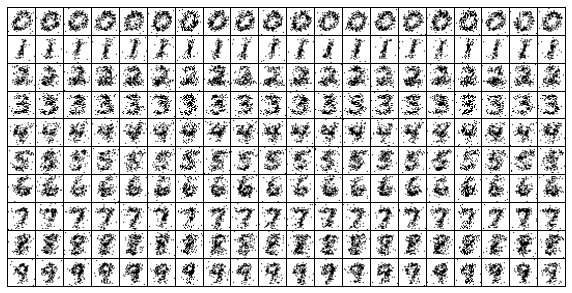

In [26]:
def P10(num_examples):

### STUDENT START ###
    BinomialNB_model = BernoulliNB(binarize=0.333)
    BinomialNB_model.fit(mini_train_data, mini_train_labels)
    probs = np.exp(BinomialNB_model.feature_log_prob_)
    plt.rc('image', cmap='Greys')
    plt.figure(figsize=(10, 5), dpi=X.shape[1])
    # For each digit (from 0 to 9)
    for i in range(len(np.unique(Y))):
        # Create a ndarray with the features of
            # "num_examples" examples of digit "i"
        # For each of the "num_examples" examples
        for j in range(num_examples):
            # Create subplot
                # (from 1 to "num_digits"*"num_examples" of each digit)
            example = np.where(probs[i,:]>np.random.rand(X.shape[1]),
                               1,0)
            plt.subplot(len(np.unique(Y)), num_examples, 
                        i * num_examples + j + 1)
            plt.subplots_adjust(wspace=0, hspace=0)
            # Hide tickmarks and scale
            ax = plt.gca()
            # ax.set_axis_off() # Also hide axes (frame)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            # Plot the corresponding digit
            dim = int(np.sqrt(X.shape[1]))
            digit = example.reshape((dim,dim))
            plt.imshow(digit)
### STUDENT END ###

P10(20)

ANSWER:

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  26    accuracy = 0.423
p(pred) <= 0.9990000000000    total =  90    accuracy = 0.456
p(pred) <= 0.9999900000000    total =  66    accuracy = 0.621
p(pred) <= 0.9999999000000    total =  64    accuracy = 0.625
p(pred) <= 0.9999999990000    total =  56    accuracy = 0.750
p(pred) <= 0.9999999999900    total =  57    accuracy = 0.807
p(pred) <= 0.9999999999999    total =  73    accuracy = 0.836
p(pred) <= 1.0000000000000    total = 568    accuracy = 0.961


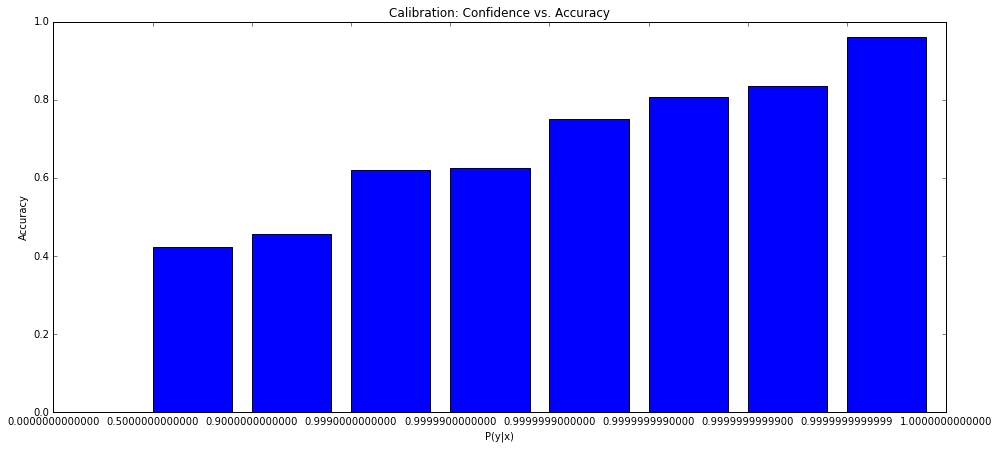

In [28]:
def P11(buckets, correct, total):
    
### STUDENT START ###
    # Create a Binomial NB model
    BinomialNB_model = BernoulliNB(alpha=nb.best_params_['alpha'], binarize=0.333)
    # Fit it with the mini training set
    BinomialNB_model.fit(mini_train_data, mini_train_labels)
    # Predict labels and probabilities of dev set
    dev_predicted_labels = BinomialNB_model.predict(dev_data)
    dev_predicted_probs = BinomialNB_model.predict_proba(dev_data)
    # Define some aux variables: buckets_copy and acc
    buckets_copy = list(buckets)
    # Each bucket ranges from the prior value to the current one: first prior value is 0 
    buckets_copy.insert(0, 0.)
    # Accuracy for each bucket (to display it)
    acc = [0.]*len(buckets)
    # For every bucket (-> depends on input to function)
    for i in range(1,len(buckets)+1):
        # Goes from 1 to len(buckets) because we'll use buckets_copy to compare probabilities
        label_into_bucket = np.zeros(dev_predicted_labels.shape[0])
        count_correct = 0
        count_total = 0
        # For every prediction (for every item in dev set -> 1000)
        for j in range(dev_predicted_probs.shape[0]):
            # Search the maximum posterior probability (it may correspond to the correct label or not)
            prob = dev_predicted_probs[j, dev_predicted_probs[j].argmax()]
            # If that maximum posterior is inside the current bucket (threshold under study) we take it into account
            label_into_bucket[j] = np.where((prob <= buckets_copy[i]) & (prob > buckets_copy[i-1]), 1, 0)
            # If posterior was within the current bucket for that item
            if label_into_bucket[j] == 1:
                # increase count of total
                count_total +=1
                # If prediction was correct
                if dev_predicted_labels[j] == dev_labels[j]:
                    # increase count of correct
                    count_correct += 1
        # Count total and correct cases for each particular item
        # Make at least one of them a float to allow non-integer division
        correct[i-1] = float(count_correct)
        total[i-1] = float(count_total)
        # Update acc(uracy) (used to display it)
        if (total[i-1] > 0): acc[i-1] = correct[i-1] / total[i-1]
    
    # Display Posterior vs. Accuracy
    buck = ["{:.13f}".format(i) for i in buckets_copy]
    plt.figure(figsize=(16,7))
    fig = plt.bar(range(len(buckets)), acc)
    plt.title('Calibration: Confidence vs. Accuracy')
    plt.xlabel('P(y|x)')
    plt.ylabel('Accuracy')
    ax = plt.gca()
    ax.set_xticklabels(buck)              
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy) )

ANSWER:

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [31]:
def P12():
### STUDENT START ###
    # create binary data
    binary_mini_train_data = []
    for pic in mini_train_data:
        binary_mini_train_data.append(pic//.5)
    
    binary_dev_data = []
    for pic in dev_data:
        binary_dev_data.append(pic//.5)

    # create classifier, calculate initial accuracy
    classifier = BernoulliNB()
    classifier.fit(binary_mini_train_data, mini_train_labels)
    predicted = classifier.predict(binary_dev_data)
    accuracy = sum(predicted == dev_labels)*1./len(dev_labels)
    print(accuracy, " accuracy in binary")

    # calculate accuracy of individual pixels
    #penalty when wrong = half of points when right
    
    #init empty matrix
    pixel_accuracy = binary_mini_train_data[1]*0
    
    #score data points (pixels)
    for j,pic in enumerate(binary_dev_data):
        for i,pixel in enumerate(pic):
            if (pixel>0):
                if(dev_labels[j]==predicted[j]):
                    pixel_accuracy[i]+=2
                else:
                    pixel_accuracy[i]-=1

    #normalize, set cut-off level (cut lowers 25%)
    pixel_accuracy-= min(pixel_accuracy)
    theshold_weight = max(list(pixel_accuracy))/4
    pixel_accuracy-=theshold_weight
    
    #apply cut-off/threshold
    for n,pixel in enumerate(pixel_accuracy):
        if pixel>0:
            pixel_accuracy[n]=1
        if pixel<0:
            pixel_accuracy[n]=0
    

    #create data set with 
    #filter applied to low accuracy pixels
    filtered_data=[]
    for pic in binary_mini_train_data:
        filtered_data.append(pic*pixel_accuracy)
     
        #evaluate new model
    classifier.fit(filtered_data, mini_train_labels)
    predicted = classifier.predict(binary_dev_data)
    accuracy = sum(predicted == dev_labels)*1./len(dev_labels)
    print(accuracy, " new accuracy - with low accuracy pixels removed")

### STUDENT END ###

P12()

0.815  accuracy in binary
0.815  new accuracy - with low accuracy pixels removed
